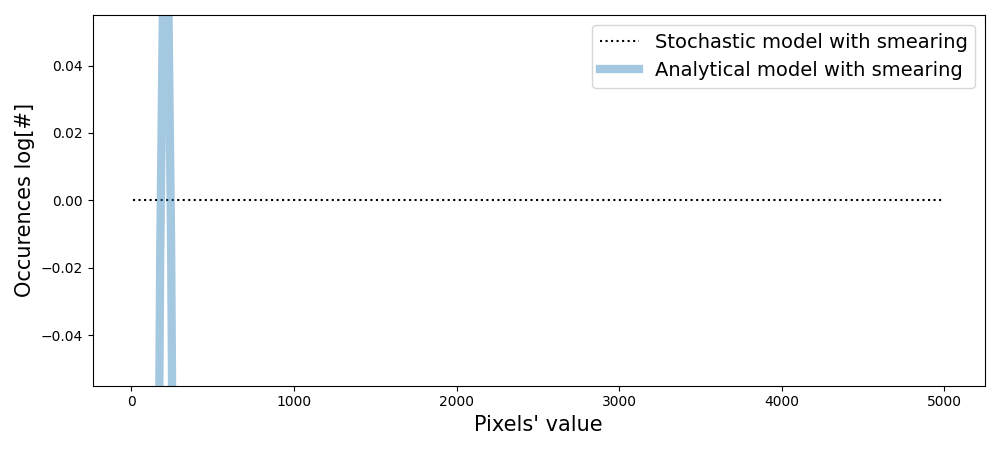

In [1]:
%matplotlib ipympl

import mpl_interactions.ipyplot as iplt
import matplotlib.pyplot as plt
import numpy as np
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.special as sps
import numpy as np
# from scipy.stats import poisson
from scipy.stats import poisson,gamma

from scipy.stats import ncx2
from scipy.special import gamma, hyp1f1, hyp0f1
from scipy.interpolate import interp1d


from pyds9plugin.Macros.Fitting_Functions.functions import EMCCDhist, EMCCD_no_smearing
from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD as EMCCD_with_smearing
 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# n_pix = 10 ** 5
# def simulate_emccd_image(
#     ConversionGain,
#     EmGain,
#     Bias,
#     RN,
#     Smearing,
#     SmearExpDecrement,
#     flux,
#     sCIC=0,
#     n_registers=604,
# ):
#     """Silumate EMCCD histogram
#     flux = flux + dark + CIC 
#     im = ConversionGain * gamma( poisson(np.nanmax([flux, 0]), abs(EmGain) )
#     gamma( poisson(1 * id_scic), np.power(EmGain, np.random.randint(1, n_registers, size=id_scic.shape)  / n_registers)
#     smearing(im) + normal(Bias, abs(RN * ConversionGain))

#     """
#     import numpy as np
#     from scipy.sparse import dia_matrix

#     # recover number of pixels to generate distributions

#     n = 1
#     # im = np.zeros(int(n_pix))  #
#     im = np.zeros((1000, int(n_pix / 1000)))
#     # print(flux)
#     imaADU = np.random.gamma(np.random.poisson(np.nanmax([flux, 0]), size=im.shape), abs(EmGain))
#     # changing total sCIC (e-) into the percentage of pixels experiencing spurious electrons
#     # TODO maybe should be changed
#     p_sCIC = (1-np.exp(-sCIC))#sCIC 
#     # p_sCIC = (1-np.exp(-sCIC))#sCIC 
#     # pixels in which sCIC electron might appear
#     id_scic = np.random.rand(im.shape[0], im.shape[1]) < p_sCIC
#     # stage of the EM register at which each sCIC e- appear
#     register = np.random.randint(1, n_registers, size=id_scic.shape)
#     # Compute and add the partial amplification for each sCIC pixel
#     # when f=1e- gamma is equivalent to expoential law
#     # should we add poisson here?
#     imaADU += np.random.gamma(np.random.poisson(1 * id_scic), np.power(EmGain, register / n_registers))
#     # imaADU += np.random.gamma(1 * id_scic, np.power(EmGain, register / n_registers))
#     # imaADU[id_scic] += np.random.gamma(1, np.power(EmGain, register / n_registers))
#     imaADU *= ConversionGain
#     # smearing data
#     def variable_smearing_kernels(
#         image, Smearing=0.7, SmearExpDecrement=50000/2, type_="exp"
#     ):
#         """Creates variable smearing kernels for convolution or inversion
#         """
#         import numpy as np
#         n = 30
#         smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
#         if type_ == "exp":
#             smearing_kernels = np.exp(
#                 -np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length
#             )
#         else:
#             assert 0 <= Smearing <= 1
#             smearing_kernels = np.power(Smearing, np.arange(n))[
#                 :, np.newaxis, np.newaxis
#             ] / np.ones(smearing_length.shape)
#         smearing_kernels /= smearing_kernels.sum(axis=0)
#         return smearing_kernels

#     if Smearing > 0:
#         n=30
#         # smearing_kernels = np.exp(-np.arange(n)[:, np.newaxis, np.newaxis] / Smearing)
#         # smearing_kernels /= smearing_kernels.sum(axis=0)
#         smearing_kernels = variable_smearing_kernels(
#             imaADU, Smearing, SmearExpDecrement
#         )
#         n_smearing = smearing_kernels.shape[0]
#         offsets = np.arange(n_smearing)
#         A = dia_matrix(
#             (smearing_kernels.reshape((n_smearing, -1)), offsets),
#             shape=(imaADU.size, imaADU.size),
#         )
#         imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
#     # adding read noise and bias
#     read_noise = np.random.normal(0, abs(RN * ConversionGain), size=im.shape)
#     imaADU += Bias
#     imaADU += read_noise
#     return imaADU




# def EMCCDhist(
#     x,
#     bias=[1e3, 4.5e3, 1194],
#     RN=[0, 350, 53],
#     EmGain=[100, 10000, 5000],
#     flux=[0.0001, 1, 0.04],
#     sCIC=[0, 1, 0],
#     smearing=0,
# ):
#     """
#     Stochastic model for EMCCD histogram.
#     RN : Read noise in e-/pix
#     EmGain : amplificaiton gain in e-/e-
#     flux : incoming charges in e-/pix
#     smearing : exponential length in pixel of the charge decay due to poor CTE
#     sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
#     """
#     # def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0],SmearExpDecrement=[1.5e3,1.5e5,15e4]):
#     from scipy.sparse import dia_matrix
#     import inspect
#     from astropy.table import Table
#     # from matplotlib.widgets import Button
#     import numpy as np

#     # if bias > 1500:
#     #     ConversionGain = 0.53  # 1/4.5 #ADU/e-  0.53 in 2018
#     # else:
#     #     ConversionGain = 1 / 4.5  # ADU/e-  0.53 in 2018
#     ConversionGain = 1  # /4.5


#     # print("flux=",flux,"Smearing=", smearing)
#     imaADU = simulate_emccd_image(
#         ConversionGain=ConversionGain, 
#         EmGain=EmGain,
#         Bias=bias,
#         RN=RN,
#         Smearing=smearing,
#         SmearExpDecrement=1e10,  # 1e4,  # 1e5 #2022=1e5, 2018=1e4...
#         n_registers=604,
#         flux=flux,
#         sCIC=sCIC,
#     )

#     range = [np.nanmin(x), np.nanmax(x)]
#     y, bins = np.histogram(imaADU.flatten(), bins=[x[0] - 1] + list(x))


#     y[y == 0] = 1.0
#     # y = y / (x[1] - x[0])
#     # y = y / (bins[1] - bins[0])
#     # print(np.nansum(y))
#     return np.log10(y)











# # def EMCCD_no_smearing2(x,bias,RN,EmGain,flux,sCIC,smearing=0):
# #     n_registers = 604  # number of amplification registers
# #     ConversionGain = 1 
# #     # bin_size = np.median((x[1:] - x[:-1]))
# #     bins = x# - np.nanmin(x)
# #     gamma = np.power(EmGain,1/n_registers)
# #     if RN>0:
# #         t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)
# #     else:
# #         t1= np.ones(len(x))
# #         t1[np.argmin(x-bias)] = np.exp(-flux-sCIC)
# #         print(np.max(t1))
# #     t2 = 2/EmGain * ncx2.pdf(2*(flux),4,2*(bins-bias)/EmGain)
# #     # t3 = sCIC/m/2 * np.sum([1/gamma**i *np.exp(-(n-bias)/gamma**i) for i in np.linspace(1,m,m+1)],axis=0) * np.exp(-flux-sCIC)
# #     gamma_distribution = t1+t2
# #     if sCIC>0:
# #         gain_ = np.power(EmGain *np.sqrt(2)  , np.linspace(0, n_registers, 100) / n_registers)
# #         cic_disdribution = 2* np.exp(-flux) * np.sum([2/gaini * ncx2.pdf(2*(sCIC/n_registers),4,2*(bins-bias)/gaini) for gaini in gain_], axis=0) 
# #         cic_disdribution[bins<=bias+2*RN] =0
# #         gamma_distribution += cic_disdribution
# #         gamma_distribution[0] -= np.sum(cic_disdribution[1:])  
# #     gamma_distribution[bins<=bias] = t1[bins<=bias]
# #     diff =  gamma_distribution[bins-bias<=0][-1] + gamma_distribution[bins-bias>0][0]
# #     # gamma_distribution[bins-bias>0] = gamma_distribution[bins-bias>0]  - diff
# #     gamma_distribution[bins==bias+1] = (gamma_distribution[bins==bias]+gamma_distribution[bins==bias+2])/2
# #     return 6.2+np.log10(gamma_distribution)


# def EMCCD_with_smearing2(
#     x,
#     bias,#=[x.min(), x.max(), x[np.argmax(y)]],
#     RN,#=[5, 350, 12],
#     EmGain,#=[10, 2000, 1900],
#     flux,#=[0, 1, 0.01],
#     smearing,#=[0, 3, 0.01],
#     sCIC,#C=[0, 2, 0],
#     test=True
# ):
#     """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
#     First attempt to add smearing
#     RN : Read noise in e-/pix
#     EmGain : amplificaiton gain in e-/e-
#     flux : incoming charges in e-/pix
#     smearing : exponential length in pixel of the charge decay due to poor CTE
#     sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
#     """
#     ConversionGain = 1 
#     bin_size = np.median((x[1:] - x[:-1]))

#     energy_fraction_kept = (1-np.exp(-flux/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
   
#     gamma_distribution =  10**EMCCD_no_smearing2(x=x,bias=0,RN=5,EmGain=EmGain*energy_fraction_kept, flux=flux,sCIC=sCIC,smearing=0)

#     if (smearing>0.0)  :
#         for i in range(1,4):
#             smeared_distri = 10**EMCCD_no_smearing2(x=x,bias=0,RN=5,EmGain=EmGain*np.exp(-i/smearing), flux=flux,sCIC=0,smearing=0)   * np.exp(-i*flux) #/smearing
#             gamma_distribution[1:] +=  smeared_distri[1:]
#             gamma_distribution[0] -= np.sum(smeared_distri[1:])



#     # Addition of the bias
#     if bias > x[0]:
#         gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
#         gamma_distribution[x < bias] = 0
#     read_noise = Gaussian1DKernel(
#         stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
#     )
#     # Convolution with read noise
#     y = convolve(gamma_distribution, read_noise) #* n_pix  #
#     y[y<=0] = np.nan
#     return np.log10(y)




# def EMCCD_no_smearing(x,bias,RN,EmGain,flux,sCIC):
#     """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
#     First attempt to add smearing
#     RN : Read noise in e-/pix
#     EmGain : amplificaiton gain in e-/e-
#     flux : incoming charges in e-/pix
#     smearing : exponential length in pixel of the charge decay due to poor CTE
#     sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
#     """
#     n_registers = 604  # number of amplification registers
#     ConversionGain = 1 
#     bin_size = np.median((x[1:] - x[:-1]))
#     bins = x - np.nanmin(x)
#     distributions = []
#     pixs_sup_0 = 0  # fraction of pixels that have ADU higher than distribution limit
#     # for smearing we consider each pixel recieve x% of their flux and Then
#     # they receive the rest with a lower gain. This approximation is # NOTE:
#     # true and need to be revised. The interest is that it is then independant
#     # draws and that distributions can be convoluted.
#     # for i, (flux_, EmGain) in enumerate(zip(fluxes, emgains)):
#     gamma_distribution = 0
#     # We sum up distributions from from the different poisson output
#     if flux!=0:
#         for f in np.arange(1, 20):  
#             # careful about the 20 limit which needs to be enough at high flux
#             v = poisson.pmf(k=f, mu=np.nanmax([flux, 0])) #TODO maybe here I miss a binomial law?? At least gamma distribution seems ok!
#             # gamma distribution : https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html
#             denominator = sps.gamma(f) * (EmGain * ConversionGain) ** f
#             # print("denominator",denominator)
#             distribution = (bin_size* bins ** (f - 1)* (np.exp(-bins / (EmGain * ConversionGain)) / denominator))
#             # print("distribution",distribution)
#             n=3
#             # distribution_up = (n* bin_size* (n * bins + bins.ptp()) ** (f - 1)* (    np.exp(-(n * bins + bins.ptp()) / (EmGain * ConversionGain))    / denominator))
#             # disminush the number of pixels by the fraction above distribution range
#             # if  (np.sum(distribution_up[np.isfinite(distribution_up)])  + np.sum(distribution[np.isfinite(distribution)])  )>0:
#             #     factor = np.sum(distribution[np.isfinite(distribution_up)]) / (np.sum(distribution_up[np.isfinite(distribution_up)])  + np.sum(distribution[np.isfinite(distribution)])  )
#             # else:
#             #     factor=0
#             gamma_distribution += distribution * v
#             # pixs_sup_0 += (1 - factor) * v
#     else:
#         gamma_distribution = bins*0
#     # flux *= 2

#     gamma_distribution = flux*np.exp(-flux)/EmGain * np.exp(- bins/EmGain)  *hyp0f1(2,bins*flux/EmGain) *bin_size
#     gamma_distribution[0] = np.exp(-flux)



#     # adding sCIC and comvolving distributions as independant draws.
#     if sCIC>0:
#         # sCIC*=
#         gain_ = np.power(EmGain *np.sqrt(2)  , np.linspace(1, n_registers, 100) / n_registers)
#         cic_disdribution = np.sum([(1 / gaini) * np.exp(-bins / gaini) for gaini in gain_], axis=0)  # *n_pix/len(gain_)
#         cic_disdribution *= 1.3*np.exp(-flux)*(1-np.exp(-sCIC)) / cic_disdribution.sum()
#         gamma_distribution[1:]  += cic_disdribution[1:]
#         gamma_distribution[0] -= np.sum(cic_disdribution[1:]) 


#     # if sCIC>0:
#     #     gain_ = np.power(EmGain *np.sqrt(2) , np.linspace(0, n_registers, 100) / n_registers)
#     #     # cic_disdribution = 
#     #     sCIC /=10#n_registers
#     #     cic_disdribution =    sCIC*np.exp(-sCIC) * np.sum([1/gaini * np.exp(- bins/gaini)  *hyp0f1(2,bins*sCIC/gaini) for gaini in gain_], axis=0)  #         15*flux*np.exp(-flux)/EmGain * np.exp(- bins/EmGain)  *hyp0f1(2,bins*flux/EmGain) 
#     #     # cic_disdribution[bins<=bias+2*RN] =0
#     #     gamma_distribution += cic_disdribution
#     #     gamma_distribution[0] -= np.sum(cic_disdribution[1:])  


#     # Addition of the bias
#     if (bias > x[0]) & (bias!=0):
#         gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
#         gamma_distribution[x < bias] = 0
#     read_noise = Gaussian1DKernel(
#         stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
#     )
#     # Convolution with read noise
#     if RN>0:
#         y = convolve(gamma_distribution, read_noise) * n_pix  #
#     else:
#         y = gamma_distribution #* n_pix
#     # y /= x[1] - x[0]
#     # print(gamma_distribution)
#     # print(np.nanmin(y),np.nanmax(y))
#     y[y<=0] =np.nan
#     return np.log10(y) 






# def EMCCD_no_smearing2(x,bias,RN,EmGain,flux,sCIC,smearing=0):
#     ConversionGain=1
#     bins = x - np.nanmin(x)
#     bin_size = np.median((x[1:] - x[:-1]))

#     gamma_distribution = flux*np.exp(-flux)/EmGain * np.exp(- bins/EmGain)  *hyp0f1(2,bins*flux/EmGain) *bin_size
#     gamma_distribution[0] = np.exp(-flux)

#     # adding sCIC and comvolving distributions as independant draws.
#     if sCIC>0:
#         gain_ = np.power(EmGain *np.sqrt(2)  , np.linspace(1, n_registers, 100) / n_registers)
#         cic_disdribution = np.sum([(1 / gaini) * np.exp(-bins / gaini) for gaini in gain_], axis=0)  # *n_pix/len(gain_)
#         cic_disdribution *= 1.3*np.exp(-flux)*(1-np.exp(-sCIC)) / cic_disdribution.sum()
#         gamma_distribution[1:]  += cic_disdribution[1:]
#         gamma_distribution[0] -= np.sum(cic_disdribution[1:]) 
#     # Addition of the bias
#     if (bias > x[0]) & (bias!=0):
#         gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
#         gamma_distribution[x < bias] = 0
#     read_noise = Gaussian1DKernel(
#         stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
#     )
#     # Convolution with read noise
#     if RN>0:
#         y = convolve(gamma_distribution, read_noise) * n_pix  #
#     else:
#         y = gamma_distribution #* n_pix
#     # y /= x[1] - x[0]
#     # print(gamma_distribution)
#     # print(np.nanmin(y),np.nanmax(y))
#     # y[y<=0] =np.nan
#     # return np.log10(y) 
#     interpolated_function = interp1d(x[x<np.nanmax(x)-3*RN],np.log10(y[x<np.nanmax(x)-3*RN]), kind='linear',fill_value="extrapolate",bounds_error=False)

#     return interpolated_function(x)




# def EMCCD_with_smearing2(x,bias,RN,EmGain,flux,smearing,sCIC,):
#     """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
#     First attempt to add smearing
#     RN : Read noise in e-/pix
#     EmGain : amplificaiton gain in e-/e-
#     flux : incoming charges in e-/pix
#     smearing : exponential length in pixel of the charge decay due to poor CTE
#     sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
#     """
#     try:
#         _, y, _ = np.loadtxt("/tmp/xy.txt").T
#         # x, y =  np.array(x), np.array(y)
#     except (OSError, ValueError) as e:
#         try:
#             _, y = np.loadtxt("/tmp/xy.txt").T

#         except (OSError, ValueError) as e:
#             _, y = np.array([0, 1]), np.array([0, 1])

#     # recover number of pixels to generate distributions

#     n_registers = 604  # number of amplification registers
#     ConversionGain = 1 
#     bin_size = np.median((x[1:] - x[:-1]))

#     # energy_fraction_kept = (1-np.exp(-1/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
#     energy_fraction_kept = 1 - np.sum([np.exp(-i/smearing) for i in range(1,4)])  if smearing>0 else 1  # -np.exp(-2/smearing)-np.exp(-3/smearing)
#     # energy_fraction_kept = 1 - np.sum([np.exp(-i/smearing) for i in range(1,4)])  if smearing>0 else 1  # -np.exp(-2/smearing)-np.exp(-3/smearing)
#     gamma_distribution = 10**EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*energy_fraction_kept, flux=flux,sCIC=sCIC)

#     if smearing>0. :
#         for i in range(1,4):
#             # print(EmGain*np.exp(-i/smearing),flux)
#             # if flux>1e-3:
#             smeared_distri = 10**EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*np.exp(-i/smearing), flux=flux,sCIC=0)   * np.exp(-i*flux) #/smearing
#             # print(smeared_distri)
#             # gamma_distribution[1:] +=  smeared_distri[1:]
#             gamma_distribution[1:] = np.nansum([gamma_distribution[1:],smeared_distri[1:]],axis=0)
#             gamma_distribution[0] -= np.nansum(smeared_distri[1:])
#     # Addition of the bias

#     if bias > x[0]:
#         gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
#         gamma_distribution[x < bias] = 0
#     read_noise = Gaussian1DKernel(
#         stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
#     )
#     # Convolution with read noise
#     y = convolve(gamma_distribution, read_noise) * n_pix  #
#     # y = np.convolve(gamma_distribution, Gaussian1DKernel(stddev=RN * ConversionGain / bin_size, x_size=len(gamma_distribution)), 'same') * n_pix  #

#     # y /= x[1] - x[0]
#     y[y<1]=1
#     return np.log10(y)

# def EMCCD_with_smearing(x,bias=10,RN=10,EmGain=1000,flux=0.1,sCIC=0,smearing=0.5):
#     """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
#     First attempt to add smearing
#     RN : Read noise in e-/pix
#     EmGain : amplificaiton gain in e-/e-
#     flux : incoming charges in e-/pix
#     smearing : exponential length in pixel of the charge decay due to poor CTE
#     sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
#     """
#     # print("x=",x.min())
#     minx = np.nanmin(x) 
#     x -=  minx
#     # print("x=",x.min())
#     try:
#         _, y, _ = np.loadtxt("/tmp/xy.txt").T
#         # x, y =  np.array(x), np.array(y)
#     except (OSError, ValueError) as e:
#         try:
#             _, y = np.loadtxt("/tmp/xy.txt").T

#         except (OSError, ValueError) as e:
#             _, y = np.array([0, 1]), np.array([0, 1])

#     # recover number of pixels to generate distributions
#     RN+=0.5
#     n_registers = 604  # number of amplification registers
#     ConversionGain = 1 
#     bin_size = np.median((x[1:] - x[:-1]))

#     # energy_fraction_kept = (1-np.exp(-1/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1

#     val=np.nan#1e-500
#     energy_fraction_kept = 1 - np.sum([np.exp(-i/smearing) for i in range(1,4)])  if smearing>0 else 1  # -np.exp(-2/smearing)-np.exp(-3/smearing)
#     # energy_fraction_kept = (1-np.exp(-flux/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
#     # gamma_distribution = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)
#     y= EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)
#     n = np.sum(10**y)
#     if smearing>0:
#         first_function = interp1d(x*energy_fraction_kept,y, kind='linear',fill_value="extrapolate",bounds_error=False)#
#         gamma_distribution = 10**first_function(x)/energy_fraction_kept
#         gamma_distribution[0] = np.exp(-flux)
#     else:
#         gamma_distribution=10**y
# #     plt.figure()
#     # plt.semilogy(x,gamma_distribution,label="0")
#     if smearing>0. :
#         for i in np.arange(1,6):
#             # interpolated_function = interp1d(x*np.exp(-i/smearing),EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)/np.exp(-i/smearing), kind='linear',fill_value=val,bounds_error=False)# * np.exp(-i*flux)
#         # if np.exp(-i/smearing)>0.00001:
#             # x2 = np.array(list(x) + [1e5])#np.arange(0,np.nanmax(x)/np.exp(-i/smearing), x[1]-x[0])
#             # x2=x#-np.nanmin(x)
#             # print(x.min(),x2.min())
#             interpolated_function = interp1d(x*np.exp(-i/smearing),EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC), kind='linear',fill_value="extrapolate",bounds_error=False)#   #
#             smeared_distri = 10**interpolated_function(x)* np.exp(-i*flux)/np.exp(-i/smearing) # doit diminuer car on ajoute trop
#             # smeared_distri[smeared_distri==1]=1e500
#             gamma_distribution[1:] = np.nansum([gamma_distribution[1:],smeared_distri[1:]],axis=0)
#             gamma_distribution[0] -= np.nansum(smeared_distri[1:])
#     # gamma_distribution[0] = np.exp(-flux)
#     gamma_distribution[1:] = n *  gamma_distribution[1:]/np.sum(gamma_distribution)

# #     plt.legend()
# #     plt.show()
#     # Addition of the bias
#     x += minx

#     if bias > x[0]:
#         gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
#         gamma_distribution[x < bias] = 0
#     read_noise = Gaussian1DKernel(
#         stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
#     )
#     # Convolution with read noise
#     y = convolve(gamma_distribution, read_noise) * n_pix  #
#     # y = np.convolve(gamma_distribution, Gaussian1DKernel(stddev=RN * ConversionGain / bin_size, x_size=len(gamma_distribution)), 'same') * n_pix  #

#     # y /= x[1] - x[0]
#     # y[y<1]=1
#     # return np.log10(y)
#     interpolated_function = interp1d(x[x<np.nanmax(x)-3*RN],np.log10(y[x<np.nanmax(x)-3*RN]), kind='linear',fill_value="extrapolate",bounds_error=False)

#     return interpolated_function(x)




# def EMCCD_no_smearing(x,bias,RN,EmGain,flux,sCIC):
#     """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
#     First attempt to add smearing
#     RN : Read noise in e-/pix
#     EmGain : amplificaiton gain in e-/e-
#     flux : incoming charges in e-/pix
#     smearing : exponential length in pixel of the charge decay due to poor CTE
#     sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
#     """
#     n_registers = 604  # number of amplification registers
#     ConversionGain = 1 
#     bin_size = np.median((x[1:] - x[:-1]))
#     bins = x - np.nanmin(x) 
#     gamma_distribution = flux*np.exp(-flux)/EmGain * np.exp(- bins/EmGain)  *hyp0f1(2,bins*flux/EmGain) *bin_size
#     # gamma_distribution = flux*np.exp(-flux)/EmGain * np.exp(- (bins-bias)/EmGain)  *hyp0f1(2,(bins-bias)*flux/EmGain) *bin_size
#     gamma_distribution[0] = np.exp(-flux)

#     # adding sCIC and comvolving distributions as independant draws.
#     if sCIC>0:
#         gain_ = np.power(EmGain *np.sqrt(2)  , np.linspace(1, n_registers, 100) / n_registers)
#         cic_disdribution = np.sum([(1 / gaini) * np.exp(-bins / gaini) for gaini in gain_], axis=0)  # *n_pix/len(gain_)
#         cic_disdribution *= 2*np.exp(-flux)*(1-np.exp(-sCIC)) / cic_disdribution.sum()
#         gamma_distribution[1:]  += cic_disdribution[1:]
#         gamma_distribution[0] -= np.sum(cic_disdribution[1:]) 
#     if bias is not None:
#         if (bias > x[0]) :
#             gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
#             gamma_distribution[x < bias] = 0
#             # interpolated_function = interp1d(bins-bias,np.log10(gamma_distribution), kind='linear',fill_value="extrapolate",bounds_error=False)
#             # gamma_distribution = 10**interpolated_function(x)

#     # Convolution with read noise
    # if RN>0:
    #     read_noise = Gaussian1DKernel(stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10))
    #     y = convolve(gamma_distribution, read_noise) * n_pix  #
    # else:
    #     y = gamma_distribution #* n_pix

#     # y[y<=0] =np.nan
#     # return y#np.log10(y) 
#     interpolated_function = interp1d(x[x<np.nanmax(x)-3*RN],np.log10(y[x<np.nanmax(x)-3*RN]), kind='linear',fill_value="extrapolate",bounds_error=False)

#     return interpolated_function(x)
# def EMCCD_dev_wo(x,bias,RN,EmGain,flux,smearing,sCIC,test=False):
#     return EMCCD_dev(x,bias,RN,EmGain,flux,smearing,sCIC,test=test)



# def five_sigma(x, bias=np.linspace(20,1000), RN=np.linspace(20,100),EmGain=np.linspace(1000,4000),flux=np.linspace(0.0,0.1),sCIC=np.linspace(0,0.1),smearing=(0,1.4)):
#     # a = 10**EMCCDhist(x, bias=bias, RN=RN,EmGain=EmGain,flux=flux,sCIC=sCIC,smearing=smearing)
#     # flux=np.nansum(a[x>bias+5.5*RN]) / np.nansum(a)
#     print(bias)
#     flux=bias
#     return f"5 sigma limit = %0.3f"%(flux)

 

def EMCCD0 (
    x,
    bias=1,#[x.min(), x.max(), x[np.argmax(y)]],
    RN=[5, 350, 12],
    EmGain=[10, 2000, 1900],
    flux=[0, 1, 0.01],
    smearing=[0, 3, 0.01],
    sCIC=[0, 2, 0],
):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    from astropy.convolution import Gaussian1DKernel, convolve
    import scipy.special as sps
    import numpy as np
    from scipy.stats import poisson,gamma
    from scipy.integrate import quad
    from scipy.interpolate import interp1d

    try:
        _, y, _ = np.loadtxt("/tmp/xy.txt").T
        # x, y =  np.array(x), np.array(y)
    except (OSError, ValueError) as e:
        try:
            _, y = np.loadtxt("/tmp/xy.txt").T

        except (OSError, ValueError) as e:
            _, y = np.array([0, 1]), np.array([0, 1])

    # recover number of pixels to generate distributions
    try:
        # y = globals()["y"]
        n_pix = np.sum(10 ** y)
    except TypeError:
        n_pix = 10 ** 6.3
    # print(np.log10(n_pix))
    minx = np.nanmin(x) 
    x -=  minx

    n_registers = 604  # number of amplification registers
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))

    # energy_fraction_kept = (1-np.exp(-1/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1

    val=np.nan#1e-500
    energy_fraction_kept = 1 - np.sum([np.exp(-i/smearing) for i in range(1,2)])  if smearing>0 else 1  # -np.exp(-2/smearing)-np.exp(-3/smearing)
    # energy_fraction_kept = (1-np.exp(-flux/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
    # gamma_distribution = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)
    y= EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)
    n = np.sum(10**y)
    first_function = interp1d(x*energy_fraction_kept,y, kind='linear',fill_value="extrapolate",bounds_error=False)#
    gamma_distribution = 10**first_function(x)/energy_fraction_kept
    gamma_distribution[0] = np.exp(-flux)
#     plt.figure()
    # plt.semilogy(x,gamma_distribution,label="0")
    # if smearing>0. :
    #     for i in np.arange(1,2):
    #         # interpolated_function = interp1d(x*np.exp(-i/smearing),EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)/np.exp(-i/smearing), kind='linear',fill_value=val,bounds_error=False)# * np.exp(-i*flux)
    #     # if np.exp(-i/smearing)>0.00001:
    #         # x2 = np.array(list(x) + [1e5])#np.arange(0,np.nanmax(x)/np.exp(-i/smearing), x[1]-x[0])
    #         x2=x
    #         interpolated_function = interp1d(x2*np.exp(-i/smearing),EMCCD_no_smearing(x=x2,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC), kind='linear',fill_value="extrapolate",bounds_error=False)#   #
    #         smeared_distri = 10**interpolated_function(x)* np.exp(-i*flux)/np.exp(-i/smearing) # doit diminuer car on ajoute trop
    #         # smeared_distri[smeared_distri==1]=1e500
    #         # gamma_distribution[1:] = np.nansum([gamma_distribution[1:],smeared_distri[1:]],axis=0)
    #         # gamma_distribution[0] -= np.nansum(smeared_distri[1:])
            # gamma_distribution[0] = np.exp(-flux) - np.nansum(smeared_distri[1:])
    # gamma_distribution[1:] = n *  gamma_distribution[1:]/np.sum(gamma_distribution)
    gamma_distribution[0] = 0

#     plt.legend()
#     plt.show()
    # Addition of the bias
    x +=  minx
    if bias > x[0]:
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    if RN>0:
        read_noise = Gaussian1DKernel(stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10))
        y = convolve(gamma_distribution, read_noise) * n_pix  #
    else:
        y = gamma_distribution #* n_pix
    # y = np.convolve(gamma_distribution, Gaussian1DKernel(stddev=RN * ConversionGain / bin_size, x_size=len(gamma_distribution)), 'same') * n_pix  #

    # y /= x[1] - x[0]
    # y[y<1]=1
    # return np.log10(y)
    interpolated_function = interp1d(x[x<np.nanmax(x)-3*RN],np.log10(y[x<np.nanmax(x)-3*RN]), kind='linear',fill_value="extrapolate",bounds_error=False)

    return interpolated_function(x)




def EMCCD1 (
    x,
    bias=1,#[x.min(), x.max(), x[np.argmax(y)]],
    RN=[5, 350, 12],
    EmGain=[10, 2000, 1900],
    flux=[0, 1, 0.01],
    smearing=[0, 3, 0.01],
    sCIC=[0, 2, 0],
):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    from astropy.convolution import Gaussian1DKernel, convolve
    import scipy.special as sps
    import numpy as np
    from scipy.stats import poisson,gamma
    from scipy.integrate import quad
    from scipy.interpolate import interp1d

    try:
        _, y, _ = np.loadtxt("/tmp/xy.txt").T
        # x, y =  np.array(x), np.array(y)
    except (OSError, ValueError) as e:
        try:
            _, y = np.loadtxt("/tmp/xy.txt").T

        except (OSError, ValueError) as e:
            _, y = np.array([0, 1]), np.array([0, 1])

    # recover number of pixels to generate distributions
    try:
        # y = globals()["y"]
        n_pix = np.sum(10 ** y)
    except TypeError:
        n_pix = 10 ** 6.3
    # print(np.log10(n_pix))
    minx = np.nanmin(x) 
    x -=  minx

    n_registers = 604  # number of amplification registers
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))

    # energy_fraction_kept = (1-np.exp(-1/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1

    val=np.nan#1e-500
    energy_fraction_kept = 1 - np.sum([np.exp(-i/smearing) for i in range(1,2)])  if smearing>0 else 1  # -np.exp(-2/smearing)-np.exp(-3/smearing)
    # energy_fraction_kept = (1-np.exp(-flux/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
    # gamma_distribution = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)
    y= EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)
    n = np.sum(10**y)
    first_function = interp1d(x*energy_fraction_kept,y, kind='linear',fill_value="extrapolate",bounds_error=False)#
    gamma_distribution = 10**first_function(x)/energy_fraction_kept
    gamma_distribution[0] = np.exp(-flux)
#     plt.figure()
    # plt.semilogy(x,gamma_distribution,label="0")
    if smearing>0. :
        # for i in np.arange(1,3):
            # interpolated_function = interp1d(x*np.exp(-i/smearing),EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)/np.exp(-i/smearing), kind='linear',fill_value=val,bounds_error=False)# * np.exp(-i*flux)
        # if np.exp(-i/smearing)>0.00001:
            # x2 = np.array(list(x) + [1e5])#np.arange(0,np.nanmax(x)/np.exp(-i/smearing), x[1]-x[0])
        i=1
        x2=x
        interpolated_function = interp1d(x2*np.exp(-i/smearing),EMCCD_no_smearing(x=x2,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC), kind='linear',fill_value="extrapolate",bounds_error=False)#   #
        smeared_distri = 10**interpolated_function(x)* np.exp(-i*flux)/np.exp(-i/smearing) # doit diminuer car on ajoute trop
        i=2
        interpolated_function2 = interp1d(x2*np.exp(-i/smearing),EMCCD_no_smearing(x=x2,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC), kind='linear',fill_value="extrapolate",bounds_error=False)#   #
        smeared_distri2 = 10**interpolated_function(x)* np.exp(-i*flux)/np.exp(-i/smearing) # doit diminuer car on ajoute trop


        # smeared_distri[smeared_distri==1]=1e500
        # gamma_distribution[1:] = np.nansum([gamma_distribution[1:],smeared_distri[1:]],axis=0)
        # gamma_distribution[0] -= np.nansum(smeared_distri[1:])
        gamma_distribution=smeared_distri
        gamma_distribution[0] = np.exp(-flux) - np.nansum(smeared_distri[1:])
        # gamma_distribution[1:] = np.nansum([gamma_distribution[1:],smeared_distri2[1:]],axis=0)
        # gamma_distribution[0]-= np.nansum(smeared_distri2[1:])
    # gamma_distribution[1:] = n *  gamma_distribution[1:]/np.sum(gamma_distribution)
#     plt.legend()
#     plt.show()
    # Addition of the bias
    x +=  minx
    if bias > x[0]:
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    if RN>0:
        read_noise = Gaussian1DKernel(stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10))
        y = convolve(gamma_distribution, read_noise) * n_pix  #
    else:
        y = gamma_distribution #* n_pix
    # y = np.convolve(gamma_distribution, Gaussian1DKernel(stddev=RN * ConversionGain / bin_size, x_size=len(gamma_distribution)), 'same') * n_pix  #

    # y /= x[1] - x[0]
    # y[y<1]=1
    # return np.log10(y)
    interpolated_function = interp1d(x[x<np.nanmax(x)-3*RN],np.log10(y[x<np.nanmax(x)-3*RN]), kind='linear',fill_value="extrapolate",bounds_error=False)

    return interpolated_function(x)



x = np.linspace(10,5000,300)
bias=100
fig, ax = plt.subplots(figsize=(10,4.5))

ylim=None#[-1,5]
# ylim=[1.2,5.1]
controls = iplt.plot(x, EMCCDhist , bias=np.linspace(200,1000), RN=np.linspace(50,100),EmGain=np.linspace(1000,3000),flux=np.linspace(0.1,1),sCIC=np.linspace(0,0.1),smearing=(0.01,1.4),ls=":",c="k", ylim=ylim, label="Stochastic model with smearing")#,fmt="."
# iplt.plot(x, EMCCD_no_smearing2,controls=controls, ylim=ylim,label="Draws")
# iplt.plot(x, EMCCD_no_smearing,controls=controls, ylim=ylim,label="Analytical")
# iplt.plot(x, EMCCD_with_smearing2, "-", controls=controls, ylim=ylim, label="FracKept que j'avais proposé avec f/sm")#,alpha=0.3)
iplt.plot(x, EMCCD_with_smearing, controls=controls, ylim=ylim, label="Analytical model with smearing",lw=6,alpha=0.4)#,alpha=0.3)
# iplt.plot(x, EMCCD0, controls=controls, ylim=ylim, label="Histogram from pixel which received 1 electron",ls="--",c="k")#,alpha=0.3)
# iplt.plot(x, EMCCD1, controls=controls, ylim=ylim, label="Histogram from pixel which received 0 electron",ls="dashdot",c="k")#,alpha=0.3)
_ = plt.legend()
# ax.set_yscale("log")
# with controls:
# iplt.title(x,five_sigma, controls=controls)

# plt.plot([bias,bias],[2,5],":k")
plt.legend(fontsize=14)
# plt.grid()
plt.xlabel("Pixels' value",fontsize=15)
plt.ylabel("Occurences log[#]",fontsize=15)
fig.tight_layout()
plt.show()


# plt.figure()
# for xi in np.linspace(0,300,3):
#     x = np.linspace(xi,3000,5000)
#     plt.plot(x,EMCCD_no_smearing(x,bias=500,RN=10,EmGain=1000,flux=0.1,sCIC=0),label=xi)##,smearing=0))
# plt.ylim((-1,5))
# plt.grid()
# plt.legend()
# plt.show()/





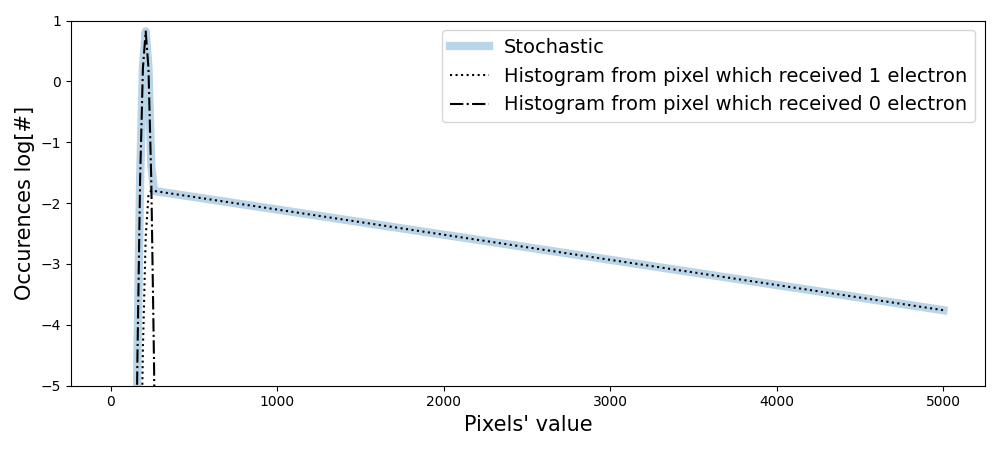

In [14]:

x = np.linspace(10,5000,300)
bias=100
fig, ax = plt.subplots(figsize=(10,4.5))

ylim=[-5,1]
# ylim=[1.2,5.1]
# controls = iplt.plot(x, EMCCDhist , bias=200, RN=np.linspace(10,100),EmGain=np.linspace(1000,3000),flux=np.linspace(0.1,5),sCIC=np.linspace(0,0.1),smearing=0.01,ls=":",c="k", ylim=ylim, label="Stochastic")#,fmt="."
# iplt.plot(x, EMCCD_no_smearing2,controls=controls, ylim=ylim,label="Draws")
# iplt.plot(x, EMCCD_no_smearing,controls=controls, ylim=ylim,label="Analytical")
# iplt.plot(x, EMCCD_with_smearing2, "-", controls=controls, ylim=ylim, label="FracKept que j'avais proposé avec f/sm")#,alpha=0.3)
controls =iplt.plot(x, EMCCD_with_smearing,  bias=200, RN=np.linspace(10,100),EmGain=np.linspace(1000,3000),flux=np.linspace(0.1,5),sCIC=np.linspace(0,0.1),smearing=0.01,ls="-",c="C0", ylim=ylim, label="Stochastic",lw=6,alpha=0.3)#,fmt="."
iplt.plot(x, EMCCD0, controls=controls, ylim=ylim, label="Histogram from pixel which received 1 electron",ls=":",c="k")#,alpha=0.3)
iplt.plot(x, EMCCD1, controls=controls, ylim=ylim, label="Histogram from pixel which received 0 electron",ls="dashdot",c="k")#,alpha=0.3)
_ = plt.legend()
# ax.set_yscale("log")
# with controls:
# iplt.title(x,five_sigma, controls=controls)

# plt.plot([bias,bias],[2,5],":k")
plt.legend(fontsize=14)
# plt.grid()
plt.xlabel("Pixels' value",fontsize=15)
plt.ylabel("Occurences log[#]",fontsize=15)
fig.tight_layout()
plt.show()

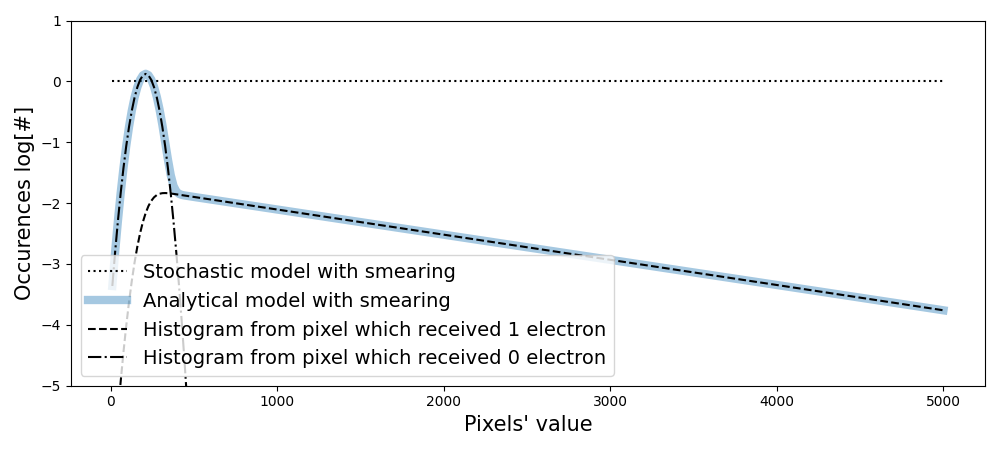

In [20]:


x = np.linspace(10,5000,300)
bias=100
fig, ax = plt.subplots(figsize=(10,4.5))

ylim=[-5,1]
# ylim=[1.2,5.1]
controls = iplt.plot(x, EMCCDhist , bias=np.linspace(200,1000), RN=np.linspace(50,100),EmGain=np.linspace(1000,3000),flux=np.linspace(0.1,5),sCIC=np.linspace(0,0.1),smearing=(0.01,1.4),ls=":",c="k", ylim=ylim, label="Stochastic model with smearing")#,fmt="."
# iplt.plot(x, EMCCD_no_smearing2,controls=controls, ylim=ylim,label="Draws")
# iplt.plot(x, EMCCD_no_smearing,controls=controls, ylim=ylim,label="Analytical")
# iplt.plot(x, EMCCD_with_smearing2, "-", controls=controls, ylim=ylim, label="FracKept que j'avais proposé avec f/sm")#,alpha=0.3)
iplt.plot(x, EMCCD_with_smearing, controls=controls, ylim=ylim, label="Analytical model with smearing",lw=6,alpha=0.4)#,alpha=0.3)
iplt.plot(x, EMCCD0, controls=controls, ylim=ylim, label="Histogram from pixel which received 1 electron",ls="--",c="k")#,alpha=0.3)
iplt.plot(x, EMCCD1, controls=controls, ylim=ylim, label="Histogram from pixel which received 0 electron",ls="dashdot",c="k")#,alpha=0.3)
_ = plt.legend()
# ax.set_yscale("log")
# with controls:
# iplt.title(x,five_sigma, controls=controls)

# plt.plot([bias,bias],[2,5],":k")
plt.legend(fontsize=14)
# plt.grid()
plt.xlabel("Pixels' value",fontsize=15)
plt.ylabel("Occurences log[#]",fontsize=15)
fig.tight_layout()
plt.show()

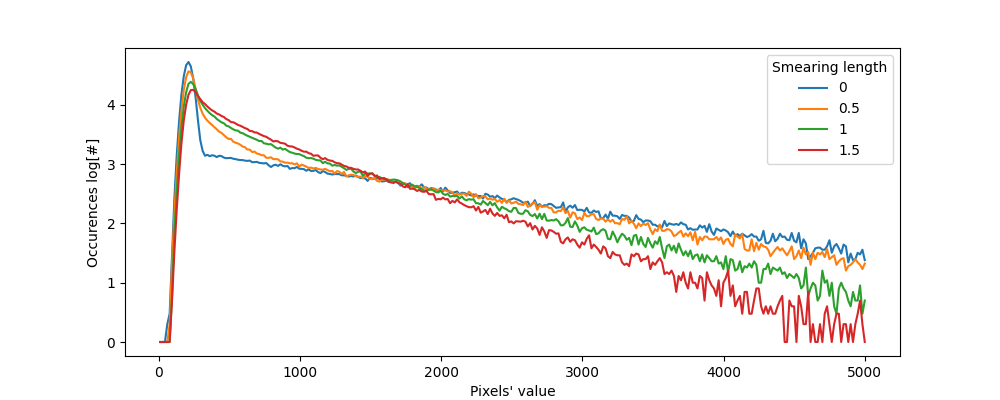

In [17]:
fig=plt.figure(figsize=(10,4))
for smearing in [0,0.5,1,1.5]:
    y = EMCCDhist(x, bias=200, RN=30,EmGain=1000,flux=0.4,sCIC=0.01,smearing=smearing)
    plt.plot(x,y,label=smearing)

plt.legend(title="Smearing length")
plt.xlabel("Pixels' value")
plt.ylabel("Occurences log[#]")
fig.get_tight_layout()
plt.show()

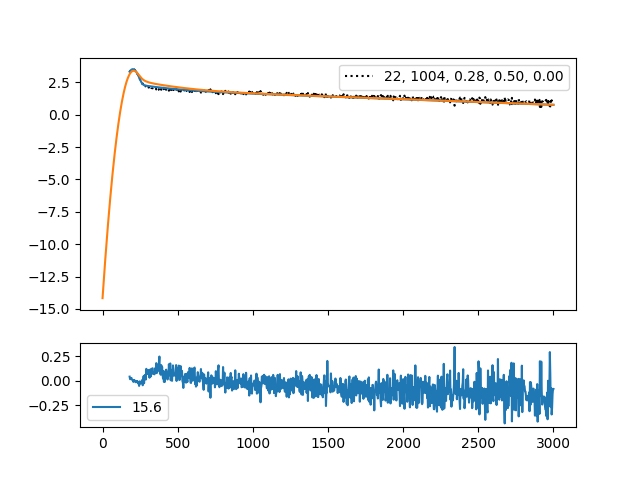

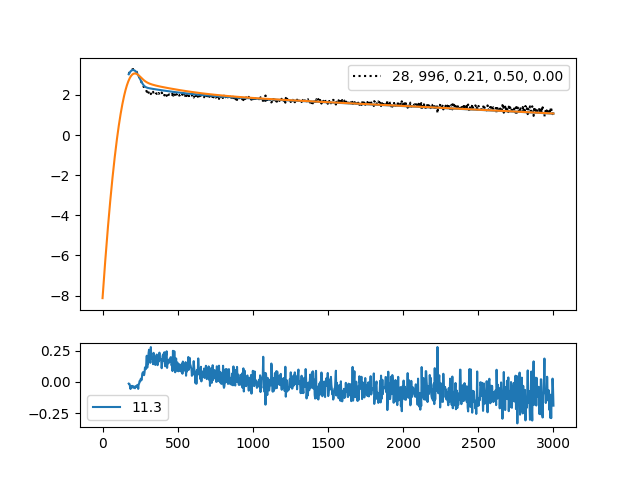

In [6]:


# from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD,EMCCDhist
from scipy.special import gamma, hyp1f1, hyp0f1
import numpy as np
from scipy.stats import ncx2
from scipy.special import jv


with open('/Users/Vincent/Nextcloud/LAM/FIREBALL/FB_VP_old/params.csv', 'a') as file:
    file.write("ReadNoise, Gain, Flux, Smearing")   

with open('/Users/Vincent/Nextcloud/LAM/FIREBALL/FB_VP_old/fit-p0.csv', 'a') as file:
    file.write("ReadNoise, Gain, Flux, Smearing")   


with open('/Users/Vincent/Nextcloud/LAM/FIREBALL/FB_VP_old/fit-p0_cic.csv', 'a') as file:
    file.write("ReadNoise, Gain, Flux, Smearing")   


for  i in range(2):
    RN_b = [20,50]
    gain_b = [500,2500]
    bias=200
    
    x = np.linspace(0,3000,1000)
    gain = np.random.randint(*gain_b)
    RN = np.random.randint(*RN_b)
    smearing = 0.5#np.random.rand()*2/3
    flux=np.random.rand()+0.01
    CIC = 0#np.random.rand()/10
    values=[bias,RN,gain,flux,smearing,CIC]
    y = 10**EMCCDhist(x,*values)
    
    
    function = lambda x, RN, EmGain, flux, smearing: EMCCD_with_smearing(
            x,
            bias=bias,
            RN=RN,
            EmGain=EmGain,
            flux=flux,
            smearing=smearing,
            sCIC=CIC)


    function_CIC = lambda x, RN, EmGain, flux, smearing, CIC: EMCCD_with_smearing(
            x,
            bias=bias,
            RN=RN,
            EmGain=EmGain,
            flux=flux,
            smearing=smearing,
            sCIC=CIC)
    
    # y_true = 
    mask = (x>bias-1*RN) &(y>=0)
    x2 = x[mask]
    y2 = np.log10(y[mask])


    # gains = np.random.randint(gain*0.5,gain*2)
    # RNs = np.random.randint(RN*0.7,RN*1.3)
    smearings=np.random.rand()*2/3
    gains = np.random.randint(*gain_b)
    RNs = np.random.randint(*RN_b)


    flux=np.random.rand()/2
    p_rand =[RNs,gains,flux,smearings,0.1]
    p_rand = values[1:]
    bounds = (RN_b[0],gain_b[0],0,0),(RN_b[1],gain_b[1],1,1)
    
##%% 
##%%

    fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, height_ratios=[3,1])
    # ax1.plot(x,np.log10(y),"k:",label="\n%i, %i, %0.2f, %0.2f, %0.2f"%(RN,gain,flux,smearing,CIC))
    ax1.plot(x2,y2,":k",label="%i, %i, %0.2f, %0.2f, %0.2f"%(RN,gain,flux,smearing,CIC))
    ax1.plot(x2,function_CIC(x2,*values[1:]),c="C0")#,label="%0.1f ➛ %0.1f"%(np.sum(np.square(np.log10(y)-y_true)),np.sum(np.square(np.log10(y)-function(x,*popt)))))
    ax1.plot(x,function(x,*values[1:-1]),c="C1")#,label="%0.1f ➛ %0.1f"%(np.sum(np.square(np.log10(y)-y_true)),np.sum(np.square(np.log10(y)-function(x,*popt)))))
    if 1==0:
        # popt,pcov = curve_fit(function,x,np.log10(y), p0=p_rand[:-1])#,bounds=bounds)
        popt,pcov = curve_fit(function,x2,y2, p0=p_rand[:-1])#,bounds=bounds)

    
        ax1.plot(x2,function(x2,*popt),label="\n%i, %i, %0.2f, %0.2f"%(popt[0],popt[1],popt[2],popt[3]),c="orange")

        # popt_cic,pcov_cic = curve_fit(function_CIC,x2,y2, p0=p_rand)
        # ax1.plot(x,function_CIC(x,*popt_cic),label="\n%i, %i, %0.2f, %0.2f, %0.2f"%(popt_cic[0],popt_cic[1],popt_cic[2],popt_cic[3],popt_cic[4]))
    # ax1.plot(x2,function(x2,*p_rand[:-1]))
        ax2.plot(x2,function(x2,*popt)-y2,label="%0.1f"%(np.sum(np.square(y2-function(x2,*popt)))),c="orange")
        ax1.set_title("\nΔRN=%i, ΔG=%i, ΔF=%0.2f, ΔS=%0.2f"%(RN-popt[0],gain-popt[1],flux-popt[2],smearing-popt[3]))
        with open('/Users/Vincent/Nextcloud/LAM/FIREBALL/FB_VP_old/params.csv', 'a') as file:
            file.write("\n%s, %s, %s, %s"%(popt[0],popt[1],popt[2],popt[3]))   
    
        with open('/Users/Vincent/Nextcloud/LAM/FIREBALL/FB_VP_old/fit-p0.csv', 'a') as file:
            file.write("\n%s, %s, %s, %s"%(RN-popt[0],gain-popt[1],flux-popt[2],smearing-popt[3]))   
    
        with open('/Users/Vincent/Nextcloud/LAM/FIREBALL/FB_VP_old/fit-p0_CIC.csv', 'a') as file:
            file.write("\n%s, %s, %s, %s"%(RN-popt_cic[0],gain-popt_cic[1],flux-popt_cic[2],smearing-popt_cic[3]))   
    
    
    ax2.plot(x2,function_CIC(x2,*values[1:])-y2,label="%0.1f"%(np.sum(np.square(y2-function_CIC(x2,*values[1:])))),c="C0")
    # plt.plot(x,function(x,*p_rand))
    # plt.ylim((0.1,4.2))
    ax1.legend()
    ax2.legend()
    plt.show()

In [15]:
?EMCCDhist

EMCCD_with_smearing(x, bias, RN, EmGain, flux, sCIC, smearing)

Signature:
EMCCDhist(
    x,
    bias=[1000.0, 4500.0, 1194],
    RN=[0, 350, 53],
    EmGain=[100, 10000, 5000],
    flux=[0.0001, 1, 0.04],
    sCIC=[0, 1, 0],
    smearing=0,
)
Docstring:
Stochastic model for EMCCD histogram.
RN : Read noise in e-/pix
EmGain : amplificaiton gain in e-/e-
flux : incoming charges in e-/pix
smearing : exponential length in pixel of the charge decay due to poor CTE
sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
File:      /var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_91526/2390651797.py
Type:      function


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_91526/2020273902.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


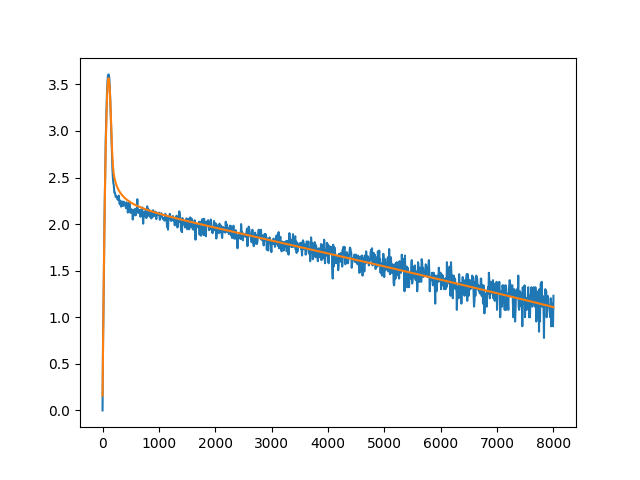

In [40]:
x = np.linspace(0,8000,1000)
gain = np.random.randint(*gain_b)
RN = np.random.randint(*RN_b)
smearing = 0.5#np.random.rand()*2/3
flux=np.random.rand()+0.01
CIC = 0#np.random.rand()/10
values=[bias,RN,gain,flux,smearing,CIC]
# y = 10**
plt.figure()
plt.plot(x,EMCCDhist(x,*values))
plt.plot(x,EMCCD_with_smearing(x,*values))
plt.show()

/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/convolution/kernels.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  self._model = models.Gaussian1D(1.0 / (np.sqrt(2 * np.pi) * stddev), 0, stddev)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/modeling/functional_models.py:213: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/modeling/functional_models.py:213: RuntimeWarning: invalid value encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/modeling/functional_models.py:213: RuntimeWarning: invalid value encountered in multiply
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


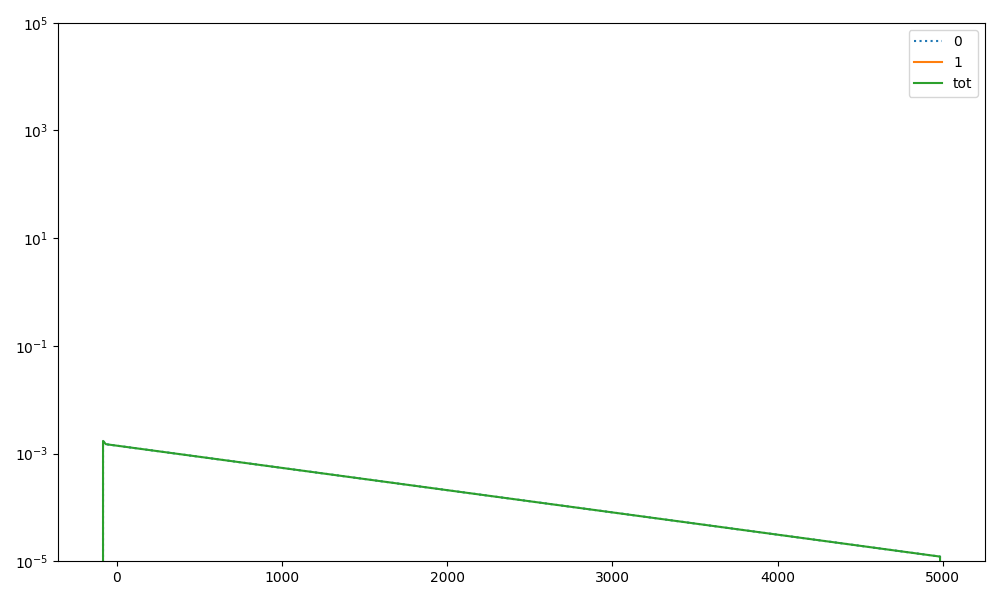

In [81]:


from scipy.interpolate import interp1d

EmGain=1000
flux=  0.1
sCIC=0
smearing=1
def EMCCD_no_smearing(x,bias,RN,EmGain,flux,sCIC):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    n_registers = 604  # number of amplification registers
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))
    bins = x - np.nanmin(x)
    distributions = []
    gamma_distribution = flux*np.exp(-flux)/EmGain * np.exp(- bins/EmGain)  *hyp0f1(2,bins*flux/EmGain) *bin_size
    gamma_distribution[0] = np.exp(-flux)

    # adding sCIC and comvolving distributions as independant draws.
    if sCIC>0:
        # sCIC*=
        gain_ = np.power(EmGain *np.sqrt(2)  , np.linspace(1, n_registers, 100) / n_registers)
        cic_disdribution = np.sum([(1 / gaini) * np.exp(-bins / gaini) for gaini in gain_], axis=0)  # *n_pix/len(gain_)
        cic_disdribution *= 1.3*np.exp(-flux)*(1-np.exp(-sCIC)) / cic_disdribution.sum()
        gamma_distribution[1:]  += cic_disdribution[1:]
        gamma_distribution[0] -= np.sum(cic_disdribution[1:]) 
    if (bias > x[0]) & (bias!=0):
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    read_noise = Gaussian1DKernel(
        stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
    )
    # Convolution with read noise
    if RN>0:
        y = convolve(gamma_distribution, read_noise) * n_pix  #
    else:
        y = gamma_distribution #* n_pix

    # y[y<=0] =np.nan
    return y#np.log10(y) 

val=1e-500#*np.nan

def f1(x,smearing):
    energy_fraction_kept = 1 - np.sum([np.exp(-i/smearing) for i in range(1,2)])  if smearing>0 else 1  # -np.exp(-2/smearing)-np.exp(-3/smearing)
    gamma_distribution = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)/energy_fraction_kept

    # first_function = interp1d(np.array( [-1e8]+list(x)+[1e8])*energy_fraction_kept, np.array( [val]+list(EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC))+[val]), kind='linear',fill_value=1e-20)# 
    first_function = interp1d(x*energy_fraction_kept, EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC), kind='linear',fill_value=val,bounds_error=False)
    # x2 = np.arange(1e-10,1e10,x[1]-x[0])
    # first_function = interp1d(x2*energy_fraction_kept, np.array( []+list(EMCCD_no_smearing(x2,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC))+[]), kind='linear')# 
    gamma_distribution = first_function(x)
    return gamma_distribution

def f2(x,smearing,i=1):
    if smearing ==0:
        return 0*x
    else:
        f = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain, flux=flux,sCIC=sCIC)/np.exp(-i/smearing)
        # interpolated_function = interp1d(np.array( [-1e20]+list(x)+[1e20])*np.exp(-i/smearing), np.array( [val]+list(f)+[val]) , kind='linear',fill_value=val)# * np.exp(-i*flux)
        interpolated_function = interp1d(x*np.exp(-i/smearing),f, kind='linear',fill_value=val,bounds_error=False)# * np.exp(-i*flux)
        smeared_distri = interpolated_function(x)
        return smeared_distri
#         return np.log10(f)


def f3(x,smearing):
    F1 = f1(x,smearing)
    F2 = f2(x,smearing,i=1)
    F3 = f2(x,smearing,i=2)
    F4 = f2(x,smearing,i=3)
    tot = F1+F2+F3+F4
    tot[0] = F1[0] - np.sum(F2[1:]+F3[1:]+F4[1:])
    return tot

fig, ax = plt.subplots(figsize=(10,6))
ylim=[1e-5,1e5]
controls = iplt.plot(x, f1,  smearing=np.linspace(0.1,1.2),ls=":", label="0",ylim=ylim)#,fmt="."
iplt.plot(x, f2, "-", controls=controls, label="1",ylim=ylim)#,alpha=0.3)
iplt.plot(x, f3, "-", controls=controls, label="tot",ylim=ylim)#,alpha=0.3)
_ = plt.legend()
ax.set_yscale("log")
# plt.plot([bias,bias],[2,5],":k")
plt.legend()
fig.tight_layout()
plt.show()





/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_9021/535907350.py:242: RuntimeWarning: divide by zero encountered in divide
  distribution = (bin_size* bins ** (f - 1)* (np.exp(-bins / (EmGain * ConversionGain)) / denominator))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_9021/535907350.py:242: RuntimeWarning: invalid value encountered in multiply
  distribution = (bin_size* bins ** (f - 1)* (np.exp(-bins / (EmGain * ConversionGain)) / denominator))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_9021/535907350.py:245: RuntimeWarning: divide by zero encountered in divide
  distribution_up = (n* bin_size* (n * bins + bins.ptp()) ** (f - 1)* (    np.exp(-(n * bins + bins.ptp()) / (EmGain * ConversionGain))    / denominator))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_9021/535907350.py:296: RuntimeWarning: invalid value encountered in log10
  return np.log10(y)
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_9021/535907350.py:

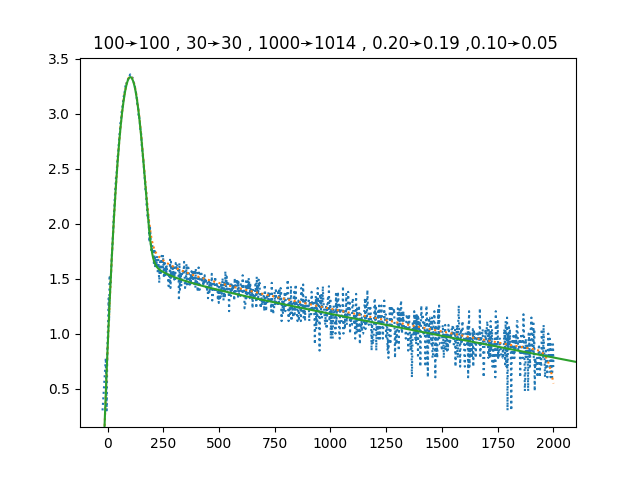

In [13]:
from pyds9plugin.DS9Utils import PlotFit1D

a
P0 = [100,30,1000,0.2,0.1,0]# bias=np.linspace(20,1000), RN=np.linspace(20,100),EmGain=np.linspace(1000,2000),flux=np.linspace(0.,1), smearing=np.linspace(0,1.2),sCIC=np.linspace(0,2)
P1 = [120,20,2000,0.5,0]
P1 = [100,54,1200,0.1,0.1]

# P1=P0.copy()
# P1[0]=100

P_best = []
x = np.linspace(-100,2000,1000)
y=EMCCDhist(x,*P0)
mask = (y>0) #& (x<np.nanmax(x)-P0[1])
fig=plt.figure()
ax = fig.gca()
ax.plot(x[mask],y[mask],":")
ys = ax.get_ylim()
xs = ax.get_xlim()
try:
    b1, b2 = 0.5*np.array(P1)-0.001, 5*np.array(P1)+0.001
    #b1, b2 = 0.9*np.array(P1)-0.001, 1.1*np.array(P1)+0.001
except TypeError:
    pass
ax.plot(x,EMCCD_no_smearing(x,*P0[:-1]),":")
# PlotFit1D(x,y,ax=ax, deg=EMCCD_with_smearing,P0=P0)
popt = PlotFit1D(x[mask],y[mask],ax=ax, deg=EMCCD_no_smearing,P0=P1)["popt"]#,bounds=(b1,b2)
popt = PlotFit1D(x[mask],y[mask],ax=ax, deg=EMCCD_with_smearing,P0=P1)["popt"]#,bounds=(b1,b2)

ax.set_ylim(ys)
ax.set_xlim(xs)
t1,t2 = P0, popt
ax.set_title("%i➛%i , %i➛%i , %i➛%i , %0.2f➛%0.2f ,%0.2f➛%0.2f "%(t1[0],t2[0],t1[1],t2[1],t1[2],t2[2],t1[3],t2[3],t1[4],t2[4]))
plt.show()

In [35]:
(b1,b2)

(array([ 4.99990e+01,  2.69990e+01,  5.99999e+02,  4.90000e-02,
        -1.00000e-03, -1.00000e-03]),
 array([3.000010e+02, 1.620010e+02, 3.600001e+03, 3.010000e-01,
        1.000000e-03, 1.000000e-03]))

About fitting:
- Adding bounds his time consuming and sometimes does not work
- The bias is impossible to fit 

0.05000748405006382 0.048770575499285984


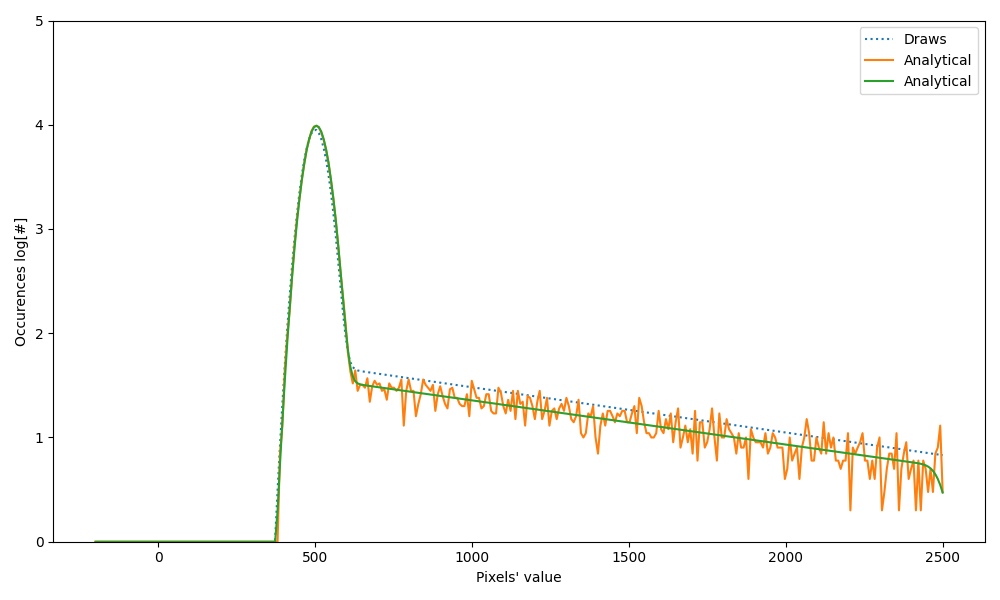

0.2422339308468915 0.22357965557092851
0.4186358572466779 0.36626376800762483
0.8478386085476195 0.6553776580171727
0.8870781623822787 0.7704027452859552
0.8929439603563343 0.8470357462347791
0.8955476567010724 0.8980908419001247
0.8973741247989782 0.9321052059616122
0.8980971005112598 0.9445823499416082
0.8987819653646979 0.9630791775051415
0.8990496344835098 0.969864181048532
0.8995018890142307 0.9799226560297669
0.8998693328873785 0.9866238995678788
0.900430145918823 0.9940628770348556
0.9007468284038007 0.9967714245807667
0.9011479471874856 0.9988303145449602
0.90139147685032 0.9994808227994135


In [299]:

# pp= 0.1#pCIC
# n= np.linspace(-100,1000,1000)#ADU
# n0=200#bias
# sigma=20#RN
# gamma=1.01
# m=604
# ps= 0.1/m##sCIC

# p1 = (1-pp-m*ps)*np.exp(-(n-n0)**2/(2*sigma**2))/(2*sigma*np.sqrt(np.pi))
# p2 = pp * 1/gamma**m *np.exp(-(n-n0)/gamma**m)
# p3 = ps * np.sum([1/gamma**i *np.exp(-(n-n0)/gamma**i) for i in np.linspace(1,m,m+1)],axis=0) 
# p2[n<=n0]=0
# p3[n<=n0]=0
# plt.semilogy(n,p1)
# plt.semilogy(n,p2)

# plt.semilogy(n,p3,".")
# plt.semilogy(n,p1+p2)
# plt.semilogy(n,p1+p2+p3)
# plt.ylim(ymin=0.00001,ymax=100)

def harpsoe(x, bias,RN,EmGain,flux,smearing,sCIC):
    m=604
    gamma = np.power(EmGain,1/m)
    p1 = (1-flux-sCIC/2)*np.exp(-(x-bias)**2/(2*RN**2))/(2*RN*np.sqrt(np.pi))
    p2 = flux * 1/gamma**m *np.exp(-(x-bias)/EmGain)
    p3 = sCIC/m/2 * np.sum([1/gamma**i *np.exp(-(x-bias)/gamma**i) for i in np.linspace(1,m,m+1)],axis=0) 
    p2[x<=bias+1]=0
    p3[x<=bias+1]=0
    p = p1+p2+p3
    p[p<=0] = np.nan
    # print(p)
    print(np.nansum(p[x>bias+5.5*RN]) / np.nansum(p), 1-np.exp(-flux) )
    return np.log10(p)+6



x = np.linspace(-200,2500,350)
bias=100
fig, ax = plt.subplots(figsize=(10,6))
def EMCCD_dev_wo(x,bias,RN,EmGain,flux,smearing,sCIC,test=False):
    return EMCCD_dev(x,bias,RN,EmGain,flux,smearing,sCIC,test=test)
ylim=[0,5]
# ylim=[None,None]
controls = iplt.plot(x,  harpsoe, bias=500, RN=np.linspace(30,100),EmGain=np.linspace(1000,2000),flux=np.linspace(0.05,10), smearing=np.linspace(0,1.2),sCIC=np.linspace(0,0.3),ls=":", ylim=ylim, label="Draws")
iplt.plot(x, EMCCDhist,controls=controls, ylim=ylim,label="Analytical")
iplt.plot(x, EMCCD_with_smearing,controls=controls, ylim=ylim,label="Analytical")
# iplt.plot(x, EMCCD_with_smearing2, "-", controls=controls, ylim=ylim, label="EMCCD dev")#,alpha=0.3)
_ = plt.legend()
# plt.plot([bias,bias],[2,5],":k")
plt.legend()
plt.xlabel("Pixels' value")
plt.ylabel("Occurences log[#]")
fig.tight_layout()
plt.show()



In [333]:
np.linspace(0,1000,1001)

array([   0.,    1.,    2., ...,  998.,  999., 1000.])

[] [0.01899809] []


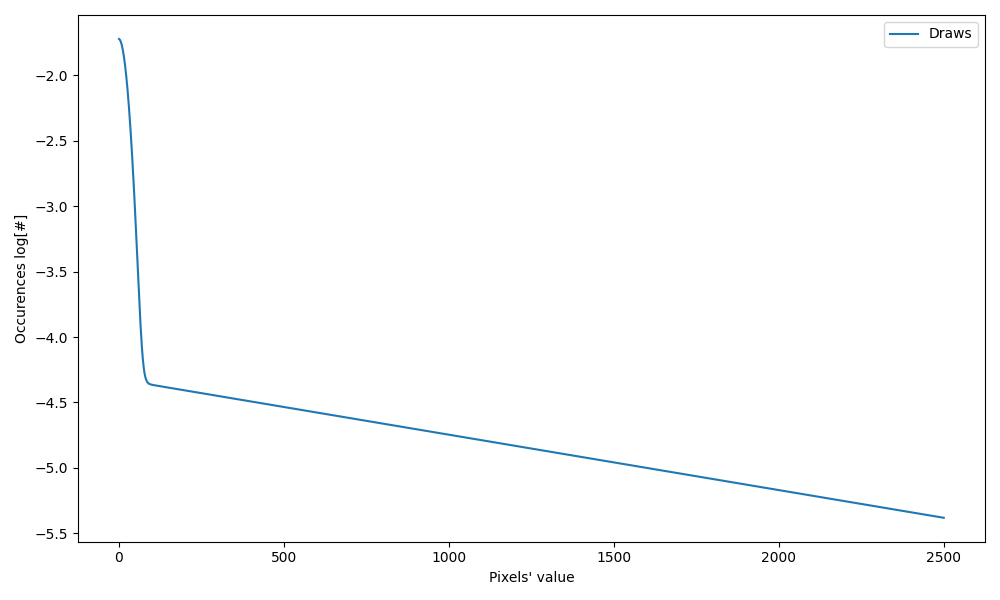

[] [0.01757104] []
[] [0.01634368] []
[] [0.01152053] []
[] [0.00925015] []
[] [0.00889977] []
[] [0.00857508] []
[] [0.00772974] []
[] [0.00748401] []


In [35]:
import numpy as np

n = np.linspace(1,2500,2500)
bias=100

def hirsch(n, g, rn, Lambda,bias,sCIC):
    m=604
    gamma = np.power(g,1/m)
    t1 = 1/(np.sqrt(2*np.pi)*rn) * np.exp(-Lambda - (n-bias)**2/(2*rn**2))
    t2 = 2/g * ncx2.pdf(2*(Lambda+sCIC),4,2*(n-bias)/g)
    t3 = sCIC/m/2 * np.sum([1/gamma**i *np.exp(-(n-bias)/gamma**i) for i in np.linspace(1,m,m+1)],axis=0) * np.exp(-Lambda-sCIC)
    # t2[n<=0]=1
    t_tot = t1+t2 + t3
    t_tot[n-bias<=0] = t1[n-bias<=0]
    # index = n.index
    print(t_tot[n==bias],t_tot[n==bias+1],t_tot[n==bias+1]-t_tot[n==bias])
    return np.log10(t_tot)
    # if n>0:
    #     return t1+t2
    # else:
    #     return t1
ylim=None#[0,5]

# ylim=[-10,-2]
fig, ax = plt.subplots(figsize=(10,6))
controls = iplt.plot(n,  hirsch,  g=np.linspace(1000,2000), rn=np.linspace(20,100),Lambda=np.linspace(0.05,15),bias=np.linspace(0,1000,1001),sCIC=np.linspace(0,0.3),ls=None, ylim=ylim, label="Draws")
_ = plt.legend()
plt.legend()
plt.xlabel("Pixels' value")
plt.ylabel("Occurences log[#]")
fig.tight_layout()
plt.show()



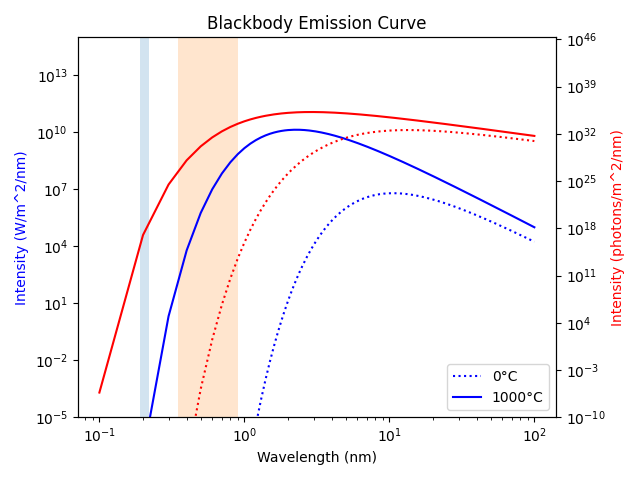

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
h = 6.626e-34  # Planck's constant in m^2 kg / s
c = 3.0e8  # Speed of light in m/s
k = 1.38e-23  # Boltzmann constant in m^2 kg / s^2 / K
# T = 20000 + 273.15  # Temperature in Kelvin (20 degrees Celsius)

# Wavelength range in micrometer
wavelengths = np.linspace(1e-1, 100, 1000) 
# Blackbody emission formula
def blackbody(wavelength, T):
    a = 2.0 * h * c**2
    b = h * c / (wavelength * k * (T+ 273.15))
    intensity = a / (wavelength**5 * (np.exp(b) - 1.0))
    return intensity


# Plotting
fig, ax1 = plt.subplots()

# Left y-axis: normal units (W/m^2/nm)
ax1.loglog(wavelengths * 1,  blackbody(wavelengths* 1e-6, 0), 'b:',label="0°C")
ax1.loglog(wavelengths * 1,  blackbody(wavelengths* 1e-6, 1000), 'b-',label="1000°C")
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Intensity (W/m^2/nm)', color='b')

ax1.fill_between(x=[190*1e-3,220*1e-3],y1=[1e18,1e18],alpha=0.2)
ax1.fill_between(x=[350*1e-3,900*1e-3],y1=[1e18,1e18],alpha=0.2)
ax1.set_ylim(ymin=1e-5,ymax=1e15)
ax2 = ax1.twinx()#functions=(lambda x: T_c*1.8 + 32.,  lambda x: (T_f - 32.)/1.8))

ax2.loglog(wavelengths * 1, blackbody(wavelengths* 1e-6, 0) / (h * c / wavelengths), 'r:')
ax2.loglog(wavelengths * 1, blackbody(wavelengths* 1e-6, 1000) / (h * c / wavelengths), 'r-')
ax2.set_ylabel('Intensity (photons/m^2/nm)', color='r')
plt.title('Blackbody Emission Curve')
ax1.legend(loc="lower right")
ax2.set_ylim(ymin=1e-10)
fig.tight_layout()
plt.show()


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_94306/578731453.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrated_flux, _ = quad(lambda w:


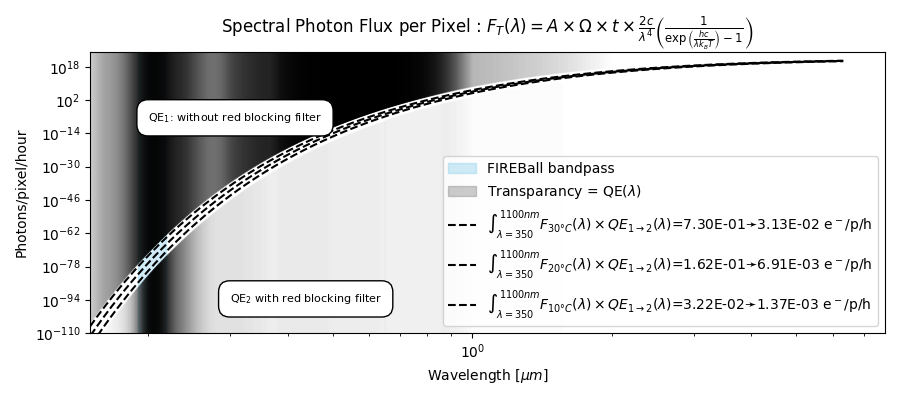

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.integrate import quad
from astropy.table import Table
QE = Table.read("/Users/Vincent/Github/FIREBallIMO/FireBallIMO/PSFDetector/efficiencies/QE_2024.txt",format="ascii")[1:-1]

def planck_law(wavelength, temperature):
    # Convert wavelength to meters for the formula
    wavelength_m = wavelength 
    # Calculate spectral radiance using Planck's Law
    first_term = (2.0 * const.h * const.c**2) / wavelength_m**5
    second_term = 1 / (np.exp((const.h * const.c) / (wavelength_m * const.k * temperature)) - 1)
    return first_term * second_term

def radiance_to_photon_flux(radiance, wavelength):
    # Convert radiance (energy) to photon flux (number of photons)
    energy_per_photon = const.h * const.c / (wavelength )
    return radiance / energy_per_photon

# Constants and parameters
# temperature = -30+273.15  # Temperature in Kelvins (0 degrees Celsius)
# time = 3600  # Time in seconds (1 hour)
# pixel_area = (13e-6)**2  # 13-micron pixel in meters squared
  # Steradian
wavelength_band = (190e-9, 220e-9)  # Wavelength range for QE is 200-210 nm

# Create wavelength array in microns for plotting
wavelengths = np.logspace(-1,0.8, 600)  # Wavelengths from 0.1 to 1 micron

def photon_flux(wavelengths,temperature,solid_angle = 2 * np.pi, pixel_area = (13e-6)**2,time = 3600):
    photon_fluxes = []
    for wl in wavelengths:
        radiance = planck_law(wl, temperature+273.15)
        photon_flux = radiance_to_photon_flux(radiance, wl)
        photon_fluxes.append(photon_flux * solid_angle * time * pixel_area)
    return photon_fluxes

# Calculate the spectral radiance for each wavelength and convert to photon flux

# Convert the range from nanometers to microns for integration and fill_between
wavelength_range_microns = (wavelength_band[0]*1e3, wavelength_band[1]*1e3)

def integrated_flux(wmin,wmax,temperature,quantum_efficiency=1,solid_angle = 2 * np.pi, pixel_area = (13e-6)**2,time = 3600):
    if type(quantum_efficiency)==float:
       integrated_flux, _ = quad(lambda w: 
       radiance_to_photon_flux(planck_law(w, temperature+273.15), w ) * solid_angle * time * pixel_area * quantum_efficiency,
    #    photon_flux(w,temperature,solid_angle = 2 * np.pi, pixel_area =pixel_area,time = time)*quantum_efficiency,
                           wmin, wmax)
    else:
        integrated_flux, _ = quad(lambda w: 
        radiance_to_photon_flux(planck_law(w, temperature+273.15), w) * solid_angle * time * pixel_area * quantum_efficiency(w*1e9),
        # photon_flux(w,temperature,solid_angle = 2 * np.pi, pixel_area =pixel_area,time = time)*quantum_efficiency(w),
                            wmin, wmax)
    return integrated_flux

from scipy.interpolate import interp1d
QE_interp0 = interp1d(QE["wave"],QE["FIREBall 3-layer ARC Model"]/100)
QE_interp1 = interp1d(QE["wave"],QE["eff. QE (1layer)"]/100)
QE_interp2 = interp1d(QE["wave"],QE["eff. QE (2 layers)"]/100)



fig, ax = plt.subplots(figsize=(9,4))        

ax.fill_between(wavelengths, 1e-200, 1e25, where=(wavelengths >= wavelength_band[0]*1e6) & (wavelengths <=  wavelength_band[1]*1e6), color='skyblue', alpha=0.4,label="FIREBall bandpass")
ax.fill_between(wavelengths, 1e-200, 1e-200, where=(wavelengths >= wavelength_band[0]*1e6) & (wavelengths <=  wavelength_band[1]*1e6), color='grey', alpha=0.4,label=r"Transparancy = QE$(\lambda$)")

Tmin = 10
Tmax=30

for i in range(len(wavelengths)):
    try:
        ax.fill_between([wavelengths[i], wavelengths[i+1]], 1e-200, 0.01*np.array([photon_flux(wavelengths*1e-6,Tmin)[i], photon_flux(wavelengths*1e-6,Tmin)[i+1]]),color="k",alpha=float(QE_interp1(1e3*wavelengths[i])))
        ax.fill_between([wavelengths[i], wavelengths[i+1]], 100*np.array([photon_flux(wavelengths*1e-6,Tmax)[i], photon_flux(wavelengths*1e-6,Tmax)[i+1]]),[1e30,1e30],color="k",alpha=float(QE_interp0(1e3*wavelengths[i])))
    except (ValueError, IndexError) as e:
        # print("i =" , wavelengths[i])
        pass

# ax.loglog(wavelengths, photon_flux(wavelengths*1e-6,-20), "k--",  label=r'$\int_{\lambda=0.35}^{0.9\mu m}F_{14°C}(\lambda)\times QE_{1 \rightarrow 2}(\lambda)$=%0.2E e$^-$/p/h'%(integrated_flux(200e-9,1000e-9,10,quantum_efficiency=test,pixel_area=1,time=1,solid_angle=1)))

wavemax = 1100
def add_line(ax,T,QE1=QE_interp0,QE2=QE_interp1,l1=350,l2=wavemax):
    ax.loglog(wavelengths, photon_flux(wavelengths*1e-6,T), "k--",  label=r'$\int_{\lambda=%i}^{%i nm}F_{%i°C}(\lambda)\times QE_{1 \rightarrow 2}(\lambda)$=%0.2E➛%0.2E e$^-$/p/h'%(l1,l2,T,integrated_flux(l1*1e-9, l2*1e-9,T,QE1), integrated_flux(l1*1e-9,l2*1e-9,T,QE2)))
    return


FB_QE = interp1d([200,201,wavemax,wavemax+1],[0,0.1,0.1,0])

add_line(ax,Tmax)#,QE1=FB_QE)
add_line(ax,(Tmax+Tmin)/2)#,QE1=FB_QE)
add_line(ax,Tmin)#,QE1=FB_QE)
# ax.loglog(wavelengths, photon_flux(wavelengths*1e-6,-20), "k--",  label=r'$\int_{\lambda=0.35}^{0.9\mu m}F_{10°C}(\lambda)\times QE_{1 \rightarrow 2}(\lambda)$=%0.2E➛%0.2E e$^-$/p/h'%(integrated_flux(200e-9,1000e-9,10,QE_interp0), integrated_flux(200e-9,1000e-9,10,QE_interp1)))
# ax.loglog(wavelengths, photon_flux(wavelengths*1e-6,-20), "k--",label=r'$\int_{\lambda=0.35}^{0.9\mu m}F_{-20°C}(\lambda)\times QE_{1 \rightarrow 2}(\lambda)$=%0.2f➛%0.2f e$^-$/p/h'% (integrated_flux(350e-9,900e-9,-20,QE_interp0),integrated_flux(350e-9,900e-9,-20,QE_interp1)))
# ax.loglog(wavelengths, photon_flux(wavelengths*1e-6,-30),"k-", label= r'$\int_{\lambda=0.35}^{0.9\mu m}F_{-30°C}(\lambda)\times QE_{1 \rightarrow 2}(\lambda)$=%0.2f➛%0.2f e$^-$/p/h'% (integrated_flux(350e-9,900e-9,-30,QE_interp0),integrated_flux(350e-9,900e-9,-30,QE_interp1)))
# ax.loglog(wavelengths, photon_flux(wavelengths*1e-6,-40), "k:",label= r'$\int_{\lambda=0.35}^{0.9\mu m}F_{-40°C}(\lambda)\times QE_{1 \rightarrow 2}(\lambda)$=%0.2f➛%0.2f e$^-$/p/h'% (integrated_flux(350e-9,900e-9,-40,QE_interp0),integrated_flux(350e-9,900e-9,-40,QE_interp1)))


plt.text(0.2,1e-8,r'QE$_1$: without red blocking filter',bbox=dict(facecolor='white',edgecolor='black',boxstyle='round,pad=1'),fontsize=8)
plt.text(0.3,1e-95,r'QE$_2$ with red blocking filter',bbox=dict(facecolor='white',edgecolor='black',boxstyle='round,pad=1'),fontsize=8)


ax.set_xlabel(r"Wavelength [$\mu m$]")
ax.set_ylabel('Photons/pixel/hour')
# ax.set_title('Spectral Photon Flux per Pixel : ' + r"$F_T(\lambda) = A \times \Omega \times t \times \int_{\lambda_1}^{\lambda_2} \frac{2 \pi c}{\lambda^4} \left( \frac{1}{\exp\left(\frac{hc}{\lambda k_B T}\right) - 1} \right) \times QE(\lambda) , d\lambda $")
ax.set_title('Spectral Photon Flux per Pixel : ' + r"$F_T(\lambda) = A \times \Omega \times t \times  \frac{2  c}{\lambda^4} \left( \frac{1}{\exp\left(\frac{hc}{\lambda k_B T}\right) - 1} \right) $")
ax.legend()#title=f"Integrated Flux: {integrated_flux:.2e} photons/pixel/hour\nin 200-210nm band")
ax.set_ylim(ymin=1e-110,ymax=1e25)
ax.set_xlim(xmin=0.15)
# Show plot
fig.tight_layout()
plt.show()

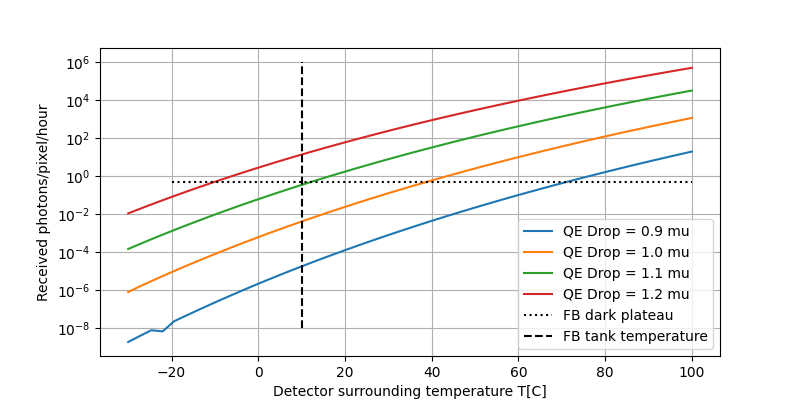

In [85]:
# integrated_flux(wmin,wmax,temperature,quantum_efficiency=1,solid_angle = 2 * np.pi, pixel_area = (13e-6)**2,time = 3600)
fig=plt.figure(figsize=(8,4))
ts = np.linspace(-30,100)
for drop in [900,1000,1100,1200]:
    plt.semilogy(ts,[integrated_flux(200*1e-9, 1500*1e-9,temperature=t,quantum_efficiency=interp1d([199,200,201,drop,drop+1,drop+2],[0,0,1,1,0,0], kind='linear',fill_value="extrapolate")) for t in ts],label="QE Drop = %0.1f mu"%(drop/1000))
plt.plot([-20,100],[0.5,0.5],":k",label="FB dark plateau")
plt.plot([10,10],[1e-8,1e6],"--k",label="FB tank temperature")
plt.xlabel("Detector surrounding temperature T[C]")
plt.legend()
plt.ylabel("Received photons/pixel/hour")
plt.grid()
fig.get_tight_layout()
plt.show()

/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_71996/540624894.py:29: RuntimeWarning: invalid value encountered in double_scalars
  sum_21 = np.array([ np.sum((QE["wave"]*QE["eff. QE (2 layers)"])[wave>w])  / np.sum((QE["wave"]*QE["eff. QE (1layer)"])[wave>w])  for w in wave ] )


0.11834664445620925
8.449753726393324


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_71996/540624894.py:30: RuntimeWarning: invalid value encountered in double_scalars
  sum_10 = np.array([ np.sum((QE["wave"]*QE["eff. QE (1layer)"])[wave>w])  / np.sum((QE["wave"]*QE["FIREBall 3-layer ARC Model"])[wave>w])  for w in wave ] )


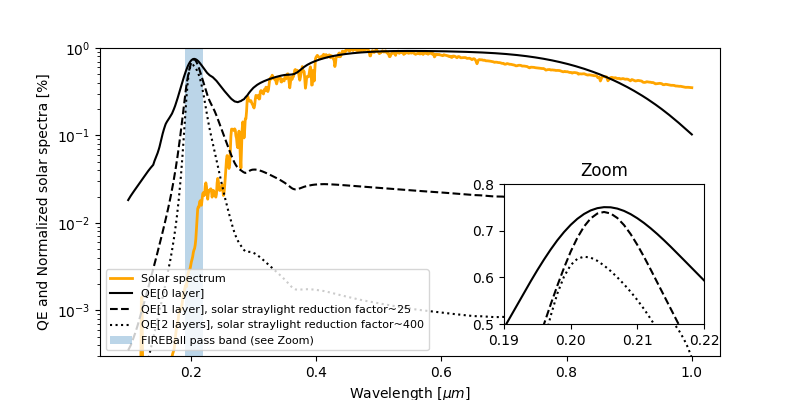

In [26]:
import sbpy
from sbpy import  calib
import astropy.units as u
from astropy.table import Table

import pandas as pd
# url = f"https://docs.google.com/spreadsheets/d/1uW2-hWWcv-l6AgtIaG9IHKCsKfP_ecP-/edit?usp=sharing&ouid=111063959106646075259&rtpof=true&sd=true"
# QE = Table.from_pandas(pd.read_csv(url))[:-2]


# sheet_id = "1uW2-hWWcv-l6AgtIaG9IHKCsKfP_ecP-"
# sheet_name = "Models"
# url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
# QE = Table.from_pandas(pd.read_csv(url))

QE = Table.read("/Users/Vincent/Github/FIREBallIMO/FireBallIMO/PSFDetector/efficiencies/QE_2024.txt",format="ascii")[1:-2]

sun =  sbpy.calib.Sun.from_default()
wave = QE["wave"]  * u.nm 
# wave = np.arange(215, 1000,1) * u.nm
fluxd = sun.observe(wave)      
fig = plt.figure(figsize=(8,4))        
ax = fig.gca()
ax.plot(wave/1000,fluxd/fluxd.max(),label="Solar spectrum",c="orange",lw=2)
ax.semilogy(QE["wave"]/1000,QE["FIREBall 3-layer ARC Model"]/100,"k-",label="QE[0 layer]")
ax.semilogy(QE["wave"]/1000,QE["eff. QE (1layer)"]/100,"k--",label="QE[1 layer], solar straylight reduction factor~25")
ax.semilogy(QE["wave"]/1000,QE["eff. QE (2 layers)"]/100,"k:",label="QE[2 layers], solar straylight reduction factor~400")

sum_21 = np.array([ np.sum((QE["wave"]*QE["eff. QE (2 layers)"])[wave>w])  / np.sum((QE["wave"]*QE["eff. QE (1layer)"])[wave>w])  for w in wave ] )
sum_10 = np.array([ np.sum((QE["wave"]*QE["eff. QE (1layer)"])[wave>w])  / np.sum((QE["wave"]*QE["FIREBall 3-layer ARC Model"])[wave>w])  for w in wave ] )
  
ax2 = fig.add_axes( [0.63, 0.19, 0.25, 0.35],alpha=0.9)
ax2.plot(QE["wave"]/1000,QE["FIREBall 3-layer ARC Model"]/100,"k-",label="QE[0 layer]")
ax2.plot(QE["wave"]/1000,QE["eff. QE (1layer)"]/100,"k--",label="QE[1 layer], solar straylight reduction factor~25")
ax2.plot(QE["wave"]/1000,QE["eff. QE (2 layers)"]/100,"k:",label="QE[2 layers], solar straylight reduction factor~400")
ax.fill_between([0.19,0.22],[0,0],[1,1],alpha=0.3,label="FIREBall pass band (see Zoom)")
ax2.set_ylim((0.5,0.8))
ax2.set_xlim((0.19,0.22))
ax2.set_title("Zoom")
mask =wave > 220* u.nm
# plt.semilogy(wave[mask],sum_21[mask],label="Ratio integrated flux 2layers/1layer (med=%0.3f)"%(np.nanmedian(sum_21[mask])))
# plt.semilogy(wave[mask],sum_10[mask],label="Ratio integrated flux 1layer/0layer (med=%0.3f)"%(np.nanmedian(sum_10[mask])))
flux_det1 = np.sum((QE["wave"]*QE["eff. QE (1layer)"])[mask])
flux_det2 = np.sum((QE["wave"]*QE["eff. QE (2 layers)"])[mask])
ax.legend(fontsize=8)
# plt.grid()
ax.set_xlabel(r"Wavelength [$\mu m$]")
ax.set_ylabel("QE and Normalized solar spectra [%]")
ax.set_ylim((0.0003,1))
# plt.xlim(xmax=1)
print(flux_det2/flux_det1)
print(flux_det1/flux_det2)
plt.show()

$$ SNR(T) = F_{True,pos}(T)\frac{S \times F_{e^->0,ADU>T}}{\sqrt{ F_{e^>0,ADU>T} \times(S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2)  + F_{e^-=0,ADU>T} \frac{\sigma_{RN}^2}{Gain} }}  \sim F_{True,pos}(T) \frac{S \sqrt{ F_{e^->0,ADU>T}}}{\sqrt{S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2 }}$$


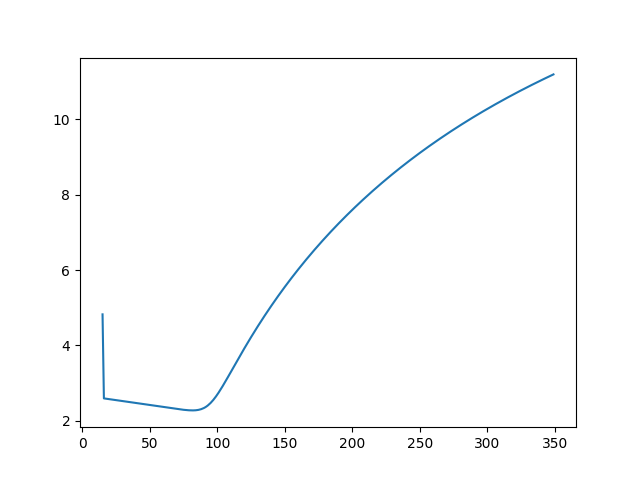

In [66]:
plt.figure()
plt.plot(EMCCD_no_smearing(x=x,bias=20,RN=0.01,EmGain=1000, flux=0.4,sCIC=0)   )
# plt.plot(EMCCD_with_smearing(x=x,bias=0,RN=0, EmGain=1000, flux=0.1,sCIC=0,smearing=20)   )
# plt.ylim((0,5))
plt.show()

In [47]:
EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=1000, flux=0.1,sCIC=0) 

array([4.95657055, 2.12360111, 2.11745367, 2.11130615, 2.10515855,
       2.09901086, 2.0928631 , 2.08671526, 2.08056734, 2.07441934,
       2.06827126, 2.0621231 , 2.05597486, 2.04982654, 2.04367814,
       2.03752966, 2.0313811 , 2.02523246, 2.01908375, 2.01293495,
       2.00678608, 2.00063712, 1.99448809, 1.98833897, 1.98218978,
       1.97604051, 1.96989116, 1.96374173, 1.95759223, 1.95144264,
       1.94529297, 1.93914323, 1.93299341, 1.92684351, 1.92069353,
       1.91454347, 1.90839334, 1.90224313, 1.89609283, 1.88994246,
       1.88379202, 1.87764149, 1.87149089, 1.86534021, 1.85918945,
       1.85303861, 1.84688769, 1.8407367 , 1.83458563, 1.82843448,
       1.82228326, 1.81613195, 1.80998057, 1.80382912, 1.79767758,
       1.79152597, 1.78537428, 1.77922251, 1.77307067, 1.76691875,
       1.76076675, 1.75461468, 1.74846253, 1.7423103 , 1.736158  ,
       1.73000562, 1.72385316, 1.71770062, 1.71154801, 1.70539533,
       1.69924256, 1.69308972, 1.68693681, 1.68078382, 1.67463